## Линейная регрессия

Рассмотрим первую простую модель линейной регрессии, которая выглядит так:
$$y = \sum_{i=1}^{n} w_ix_i + b,$$
где $x_i$ - входы модели, $y$ - выход, $w_i$ и $b$ - параметры модели, которые мы будем обучать.

Для одномерного случая формула выглядит так:
$$y = wx+b$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.stats import norm
from copy import copy

Для начала сгенерируем данные, по которым попытаемся восстановить зависимость. Возьмем простую функцию $$f(x) = 5*x+4$$, вычислим несколько значений для 100 равноотстоящих значений $x$ от -5 до 5 и добавим шума. Можно сразу заметить, что оптимальными значениями $w$ и $b$ будут числа 5 и 4 соответственно, но, предположим, мы этого не знаем.

In [2]:
def drawData(X,Y):
    plt.plot(X, Y, 'o')
    plt.title("data points")
    plt.xlabel('x',color='#1C2833')
    plt.ylabel('y',color='#1C2833')
    plt.show()


def drawLine(X, Y, w):
    predicted = np.dot(X, w)
    plt.plot(X[:,0],Y,'o')
    plt.plot(X[:,0], predicted, '-r',linewidth=4)
    plt.title('fitted line')
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
    plt.show()


def generatePointsOnLine():
    X = np.linspace(-5,5,100)
    np.random.shuffle(X)
    Y = 5*copy(X)+4
    return X, Y


def addNoise(Y):
    Y += norm.rvs(size=Y.shape[0])
    return Y


def generateDataset(draw=False):
    X, Y = generatePointsOnLine()
    Y = addNoise(Y)
    if draw:
        drawData(X,Y)
    return X,Y

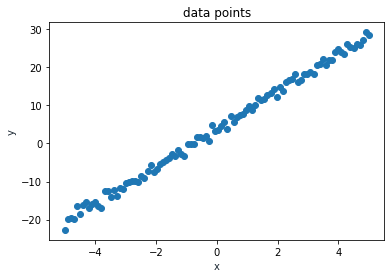

In [3]:
X, Y = generateDataset(draw=True)

Перед обучением необходимо сделать две вещи. Во-первых, разобъем наши данные на 2 выборки: тренировочную и тестовую. На тренировочной выборке будем обучать модель, а на тестовой проверять способность обобщения.

Во-вторых, применим небольшой трюк: к вектору x приклеим вектор из единиц, получим матрицу
$$\left( \begin{matrix}
x_0 & 1\\
x_1 & 1\\
... & ... \\
x_{99} & 1
\end{matrix} \right).$$

Такой прием необходим, чтобы можно было легко использовать матричные умножения, зашитые внутри языка программирования. Умножив такую матрицу на вектор$\{w, b\}$, получим ту же самую формулу $wx+b$. Использование матричных умножений предпочтительнее просто потому, что в данном виде вычисления производятся гораздо быстрее из-за использования низкоуровневых языков, на которых написаны библиотеки Python. Данный прием называется *векторизация*.

In [4]:
def trainTestSplit(X,Y):
    X = X.reshape(X.shape[0],1)
    Y = Y.reshape(Y.shape[0],1)
    X = np.hstack((X,np.ones((X.shape[0],1))))
    train_size = int(X.shape[0] * 0.8)
    X_train = X[0:train_size,:]
    Y_train = Y[0:train_size,:]
    X_test = X[train_size:,:]
    Y_test = Y[train_size:,:]
    return X, X_train,Y_train,X_test,Y_test

In [5]:
X, X_train, Y_train, X_test, Y_test = trainTestSplit(X,Y)

## Точная формула

Для линейной регрессии существует точная формула, возволяющая найти все коэфициэнты:
$$w=(X^TX)^*X^TY,$$
где * означает псевдоинверсию.

In [6]:
def computePseudoInverse(X,Y):
    w = np.dot(np.dot(linalg.inv((np.dot(X.T,X))), X.T),Y)
    return w


def computeTestError(X_test, Y_test, w):
    return np.mean(np.square(np.dot(X_test, w) - Y_test))

Test error:  1.2305148482638366
[[4.90526078]
 [3.90675821]]


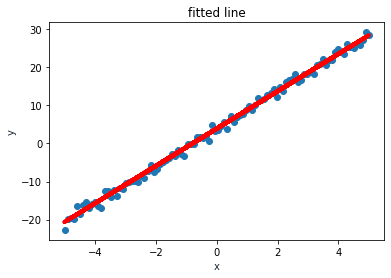

In [7]:
w = computePseudoInverse(X_train, Y_train)
print("Test error: ", computeTestError(X_test, Y_test, w))
print(w)
drawLine(X, Y, w)

## Градиентнтый спуск

В случае больших размерностей данных точная формула будет вычисляться слишком долго, поэтому в таких случаях используют приближенные методы. Рассмотрим один из наиболее популярных: *градиентный спуск*. 

In [8]:
def gradient_descent(X, Y, w, lr=1e-3, steps=10**3, print_times=20):
    history = np.zeros(steps)
    w_history = np.zeros((steps, 2, 1))
    i = 0
    print_epochs = steps//print_times
    
    for epoch in range(steps):
        # Вычисление градиентна
        error = -2*np.mean(Y - np.dot(X, w))
        grad = error*np.mean(X, axis=0)
        
        grad.resize((X.shape[1], 1))
        grad = grad/abs(grad)
        # Обновление весов
        w = w - lr * grad
        
        if epoch % print_epochs == 0:
            print('.', end='')
            
        history[i] = computeTestError(X, Y, w)
        w_history[i] = w
        i+=1

    return w, history, w_history

Test error: 273.1769325524233
[[-1]
 [ 2]]


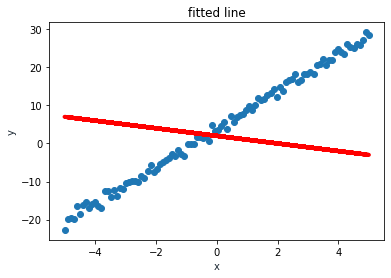

In [9]:
#w = norm.rvs(scale=1, size=X_train.shape[1]).reshape((X_train.shape[1], 1))
w = np.array([-1, 2]).reshape((X_train.shape[1], 1))

print("Test error:", computeTestError(X_test, Y_test, w))
print(w)
drawLine(X, Y, w)

....................Test error: 97.94220220195896
[[1.6]
 [4.6]]


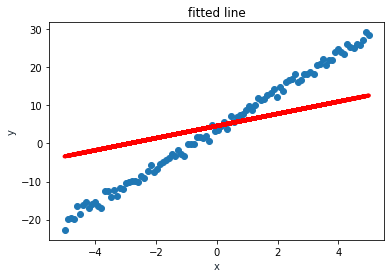

In [10]:
w, history, w_history = gradient_descent(X_train, Y_train, w, lr=1e-1)

print("Test error:", computeTestError(X_test, Y_test, w))
print(w)
drawLine(X, Y, w)

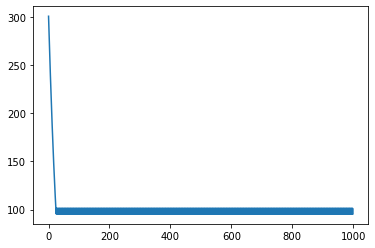

In [11]:
plt.plot(history)

In [12]:
w_grid, b_grid = np.mgrid[-10:10,
                -10:10]
error = np.zeros((w_grid.shape[0], w_grid.shape[1]))
for i in range(w_grid.shape[0]):
    for j in range(w_grid.shape[1]):
        error[i][j] = np.mean(np.square(Y - (np.dot(X, [w_grid[i][j], b_grid[i][j]]))))

История обновления весов

In [13]:
w_history.resize((w_history.shape[0], 2))

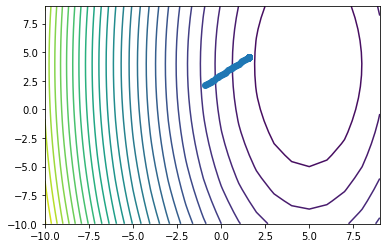

In [14]:
fig, ax = plt.subplots()

ax.contour(w_grid, b_grid, error, levels=30)
ax.plot(w_history[:, 0], w_history[:, 1], 'o')

plt.show()

#### Слишком большой learning rate

....................Test error: 273.1769325524233


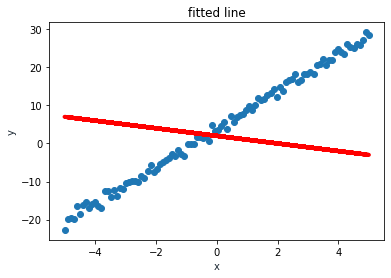

In [15]:
#w = norm.rvs(scale=1, size=X_train.shape[1]).reshape((X_train.shape[1], 1))
w = np.array([-1, 2]).reshape((X_train.shape[1], 1))

w, history, w_history = gradient_descent(X_train, Y_train, w, lr=10)

print("Test error:", computeTestError(X_test, Y_test, w))
drawLine(X, Y, w)

In [16]:
w_history.resize((w_history.shape[0], 2))

In [17]:
w_grid, b_grid = np.mgrid[-10:15,
                -10:15]
error = np.zeros((w_grid.shape[0], w_grid.shape[1]))
for i in range(w_grid.shape[0]):
    for j in range(w_grid.shape[1]):
        error[i][j] = np.mean(np.square(Y - (np.dot(X, [w_grid[i][j], b_grid[i][j]]))))

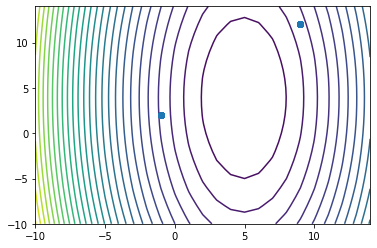

In [18]:
fig, ax = plt.subplots()

ax.contour(w_grid, b_grid, error, levels=30)
ax.plot(w_history[:, 0], w_history[:, 1], 'o')

plt.show()

#### Слишком маленький learning rate

....................Test error: 231.79915806778234
[[-0.5]
 [ 2.5]]


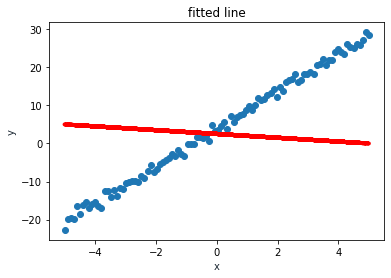

In [19]:
#w = norm.rvs(scale=1, size=X_train.shape[1]).reshape((X_train.shape[1], 1))
w = np.array([-1, 2]).reshape((X_train.shape[1], 1))

w, history, w_history = gradient_descent(X_train, Y_train, w, lr=5*1e-4)

print("Test error:", computeTestError(X_test, Y_test, w))
print(w)
drawLine(X, Y, w)

In [20]:
w_history.resize((w_history.shape[0], 2))

In [21]:
w_grid, b_grid = np.mgrid[-10:10,
                -10:10]
error = np.zeros((w_grid.shape[0], w_grid.shape[1]))
for i in range(w_grid.shape[0]):
    for j in range(w_grid.shape[1]):
        error[i][j] = np.mean(np.square(Y - (np.dot(X, [w_grid[i][j], b_grid[i][j]]))))

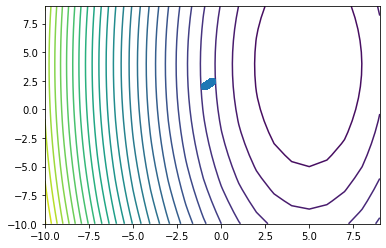

In [22]:
fig, ax = plt.subplots()

ax.contour(w_grid, b_grid, error, levels=30)
ax.plot(w_history[:, 0], w_history[:, 1], 'o')

plt.show()

## Многочлен

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.stats import norm

In [5]:
def drawData(X,Y):
    plt.plot(X,Y,'o')
    plt.title("data points")
    plt.xlabel('x',color='#1C2833')
    plt.ylabel('y',color='#1C2833')
    plt.show()


def drawPolynom(X,Y,w):
    predicted = np.dot(X,w)
    plt.plot(X[:,0],Y,'o')
    plt.plot(X[:,0], predicted, 'o',linewidth=1)
    plt.title('fitted line')
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
    plt.show()


def addNoise(Y):
    Y += norm.rvs(size=Y.shape[0])
    return Y


def generatePointsOnLine():
    X = np.linspace(-3,3,100)
    np.random.shuffle(X)
    Y = 2*np.sin(X)
    return X,Y


def generateDataset():
    X,Y = generatePointsOnLine()
    Y = addNoise(Y)
    drawData(X,Y)
    return X,Y

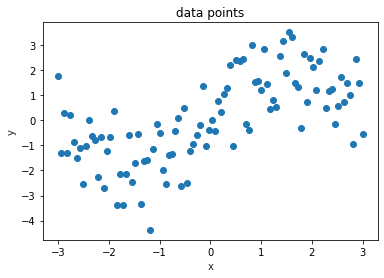

In [47]:
X_gen, Y = generateDataset()

In [48]:
def addFeatures(X, p):
    for i in range(1,p+1):
        X = np.hstack((X,(X[:,0].reshape((X[:,0].shape[0],1)))**(i + 1)))

    X = np.hstack((X,np.ones((X.shape[0],1))))
    return X


def trainTestSplit(X,Y, p=4):
    X = X.reshape(X.shape[0],1)
    Y = Y.reshape(Y.shape[0],1)
    X = addFeatures(X, p)
    train_size = int(X.shape[0] * 0.8)
    X_train = X[0:train_size,:]
    Y_train = Y[0:train_size,:]
    X_test = X[train_size:,:]
    Y_test = Y[train_size:,:]
    return X, X_train,Y_train,X_test,Y_test

In [49]:
X, X_train ,Y_train, X_test, Y_test = trainTestSplit(X_gen, Y,4)

In [50]:
def computePseudoInverse(X,Y):
    w = np.dot(np.dot(linalg.inv((np.dot(X.T,X))), X.T),Y)
    return w


def computeTestError(X_test, Y_test, w):
    return np.mean(np.abs(np.dot(X_test, w) - Y_test))

Test error:  0.8434959041792283


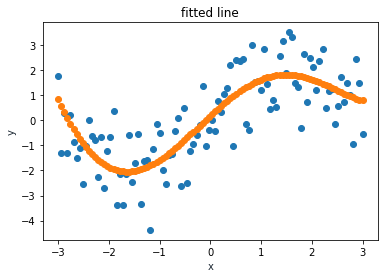

In [51]:
w = computePseudoInverse(X_train, Y_train)
print("Test error: ", computeTestError(X_test, Y_test, w))
drawPolynom(X, Y, w)

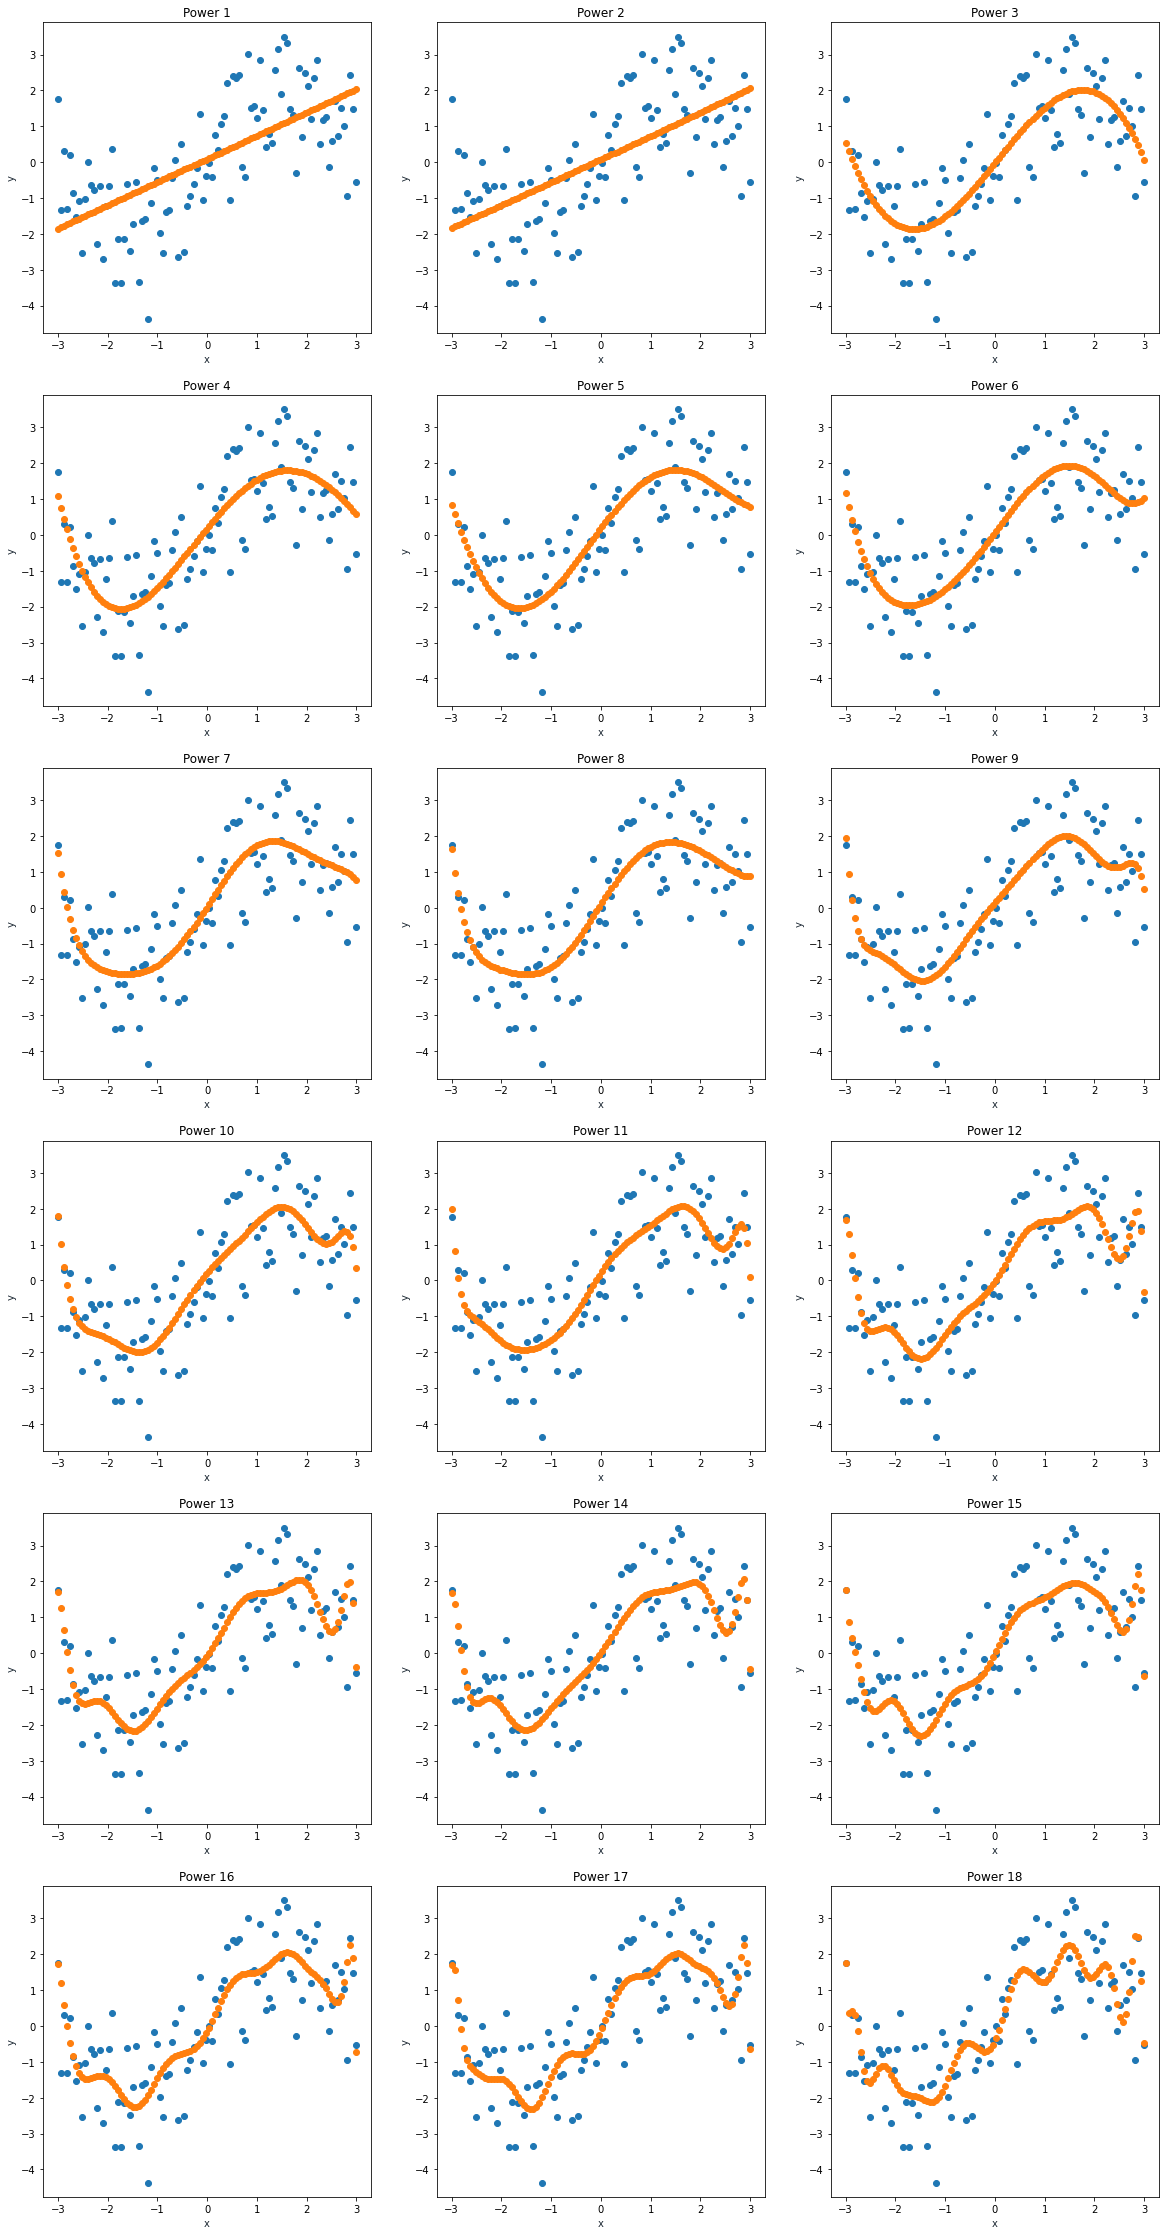

In [52]:
plt.figure(figsize=(20,40))
test_err = np.zeros(18)
train_err = np.zeros(18)
for p in range(18):
    X, X_train ,Y_train, X_test, Y_test = trainTestSplit(X_gen, Y, p)
    w = computePseudoInverse(X_train, Y_train)
    train_err[p] = computeTestError(X_train, Y_train, w)
    test_err[p] = computeTestError(X_test, Y_test, w)
    
    plt.subplot(6,3,p+1)
    plt.grid(False)
    predicted = np.dot(X,w)
    plt.plot(X[:,0],Y,'o')
    plt.plot(X[:,0], predicted, 'o',linewidth=1)
    plt.title("Power "+str(p+1))
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
plt.show()

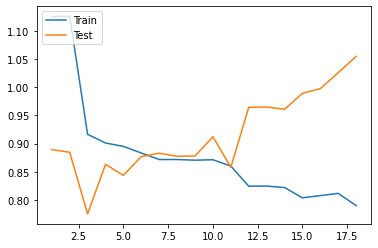

In [53]:
plt.plot(range(1, 19), train_err, label='train_error')
plt.plot(range(1, 19), test_err, label='test_error')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()